Loading relevant packages

In [ ]:
import requests
import json
from json import loads
import pandas as pd
from datetime import datetime
import time
import loading
import util
import processing
import importlib
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
importlib.reload(loading)
importlib.reload(util)
importlib.reload(processing)

<module 'processing' from '/Users/jeremyelvander/STA-141B-Final-Project/processing.py'>

Using BART API to find relevant station information (Station name, Lattitude & Longitude for mapping)

In [2]:
df = loading.stationLoad(["San Francisco", "Oakland"])

Renaming name -> station for later visualization

In [3]:
stationInfo = util.Rename(df, {"name":"station"})

In [37]:
df

,city,name,gtfs_latitude,gtfs_longitude
0,Oakland,12th St. Oakland City Center,37.803768,-122.271450
1,Oakland,Oakland International Airport,37.713238,-122.212191
2,Oakland,MacArthur,37.829065,-122.267040
3,Oakland,Lake Merritt,37.797027,-122.265180
4,Oakland,Rockridge,37.844702,-122.251371
5,Oakland,Coliseum,37.753661,-122.196869
6,Oakland,Fruitvale,37.774836,-122.224175
7,Oakland,19th St. Oakland,37.808350,-122.268602
8,Oakland,West Oakland,37.804872,-122.295140
9,San Francisco,Embarcadero,37.792874,-122.397020


Dictionary of stations for easy lookup

In [ ]:

dct = util.dfToDict(df, 'name', ['gtfs_latitude', 'gtfs_longitude'], groupby = 'city')
# print(dct)
# dct['San Francisco']['Balboa Park']

{'Oakland': {'12th St. Oakland City Center': [37.803768, -122.27145], '19th St. Oakland': [37.80835, -122.268602], 'Coliseum': [37.753661, -122.196869], 'Fruitvale': [37.774836, -122.224175], 'Lake Merritt': [37.797027, -122.26518], 'MacArthur': [37.829065, -122.26704], 'Oakland International Airport': [37.713238, -122.212191], 'Rockridge': [37.844702, -122.251371], 'West Oakland': [37.804872, -122.29514]}, 'San Francisco': {'16th St. Mission': [37.765062, -122.419694], '24th St. Mission': [37.75247, -122.418143], 'Balboa Park': [37.721585, -122.447506], 'Civic Center/UN Plaza': [37.779732, -122.414123], 'Embarcadero': [37.792874, -122.39702], 'Glen Park': [37.733064, -122.433817], 'Montgomery St.': [37.789405, -122.401066], 'Powell St.': [37.784471, -122.407974]}}


[37.721585, -122.447506]

Keys for SF and Oakland open data API's

In [5]:
secretKey = '1ef8dner8br348ez190z3z188a6pm1yluwh2wcj4xjjnlvupe'
key = '523e7ewewudxb1frvbmdftwdt'

Preparing for multi-parallel processing data loading (SF/Oakland crime, yelp reviews)

In [306]:
importlib.reload(processing)
importlib.reload(util)
importlib.reload(loading)
queriesSF = [
            ['SF', dct['San Francisco']['Balboa Park'], 0.25, 2021, 1000, 0],
             ['SF', dct['San Francisco']['Embarcadero'], 0.25, 2021, 1000, 0],
             ['SF', dct['San Francisco']['Glen Park'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['Civic Center/UN Plaza'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['24th St. Mission'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['Montgomery St.'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['16th St. Mission'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['Powell St.'], 0.25, 2021, 1000, 0]]

metaSF = [
    [['incident_category', "SF"],
     ['incident_category', "SF"],
    ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
    ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Balboa Park"},
    ["San Francisco", "Balboa Park", dct]],
 [['incident_category', "SF"],
  ['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Embarcadero"},
    ["San Francisco", "Embarcadero", dct]],
[['incident_category', "SF"],
 ['incident_category', "SF"],
["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Glen Park"},
    ["San Francisco", "Glen Park", dct]],
 [['incident_category', "SF"],
  ['incident_category', 'SF'],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Civic Center/UN Plaza"},
    ["San Francisco", "Civic Center/UN Plaza", dct]],
    [['incident_category', "SF"],
     ['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "24th St. Mission"},
    ["San Francisco", "24th St. Mission", dct]],
    [['incident_category', "SF"],
     ['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Montgomery St."},
    ["San Francisco", "Montgomery St.", dct]],
    [['incident_category', "SF"],
     ['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "16th St. Mission"},
    ["San Francisco", "16th St. Mission", dct]],
    [['incident_category', "SF"],
     ['incident_category', 'SF'],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Powell St."},
    ["San Francisco", "Powell St.", dct]]
]

subprocessesSF = [
    util.isViolent, 
    util.isDrug,
    util.dayOrNight,
    util.splitColumnsJSON,
    util.splitColumnsJSON,
    util.addColumnsJSON,
    util.radius] * len(queriesSF)

queriesOAK = [
             ['OAK', dct['Oakland']['Fruitvale'], 0.25, 2021, 1000, 0],
             ['OAK', dct['Oakland']['Rockridge'], 0.25, 2021, 1000, 0],
             ['OAK', dct['Oakland']['MacArthur'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Coliseum'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['12th St. Oakland City Center'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Oakland International Airport'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Lake Merritt'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['19th St. Oakland'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['West Oakland'], 0.25, 2021, 1000, 0]
            ]

metaOAK = [
    [
        ['description', "OAK"],
        ['description', "OAK"],
    ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
        ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Fruitvale"},
    ["Oakland", "Fruitvale", dct]],
 [
     ['description', "OAK"],
     ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Rockridge"},
    ["Oakland", "Rockridge", dct]],
[
    ['description', "OAK"],
    ['description', "OAK"],
["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "MacArthur"},
    ["Oakland", "MacArthur", dct]],
 [
     ['description', "OAK"],
     ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Coliseum"},
    ["Oakland", "Coliseum", dct]],
    [
    ['description', 'OAK'],
    ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "12th St. Oakland City Center"},
    ["Oakland", "12th St. Oakland City Center", dct]],
    [
        ['description', 'OAK'],
        ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Oakland International Airport"},
    ["Oakland", "Oakland International Airport", dct]],
    [
    ['description', 'OAK'],
    ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Lake Merritt"},
    ["Oakland", "Lake Merritt", dct]],
    [
        ['description', 'OAK'],
        ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "19th St. Oakland"},
    ["Oakland", "19th St. Oakland", dct]],
    [
        ['description', "OAK"],
        ['description'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "West Oakland"},
    ["Oakland", "West Oakland", dct]]
]

subprocessesOAK = [
    util.isViolent, 
    util.isDrug,
    util.dayOrNight,
    util.splitColumnsJSON,
    util.splitColumnsJSON,
    util.addColumnsJSON,
    util.radius] * len(queriesOAK)


reviewQuery = [
    ['https://www.yelp.com/biz/muni-bart-station-embarcadero-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/muni-bart-station-montgomery-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-muni-powell-street-station-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/muni-bart-station-civic-center-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-16th-st-mission-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-24th-st-mission-station-san-francisco-2?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-glen-park-station-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-balboa-park-station-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-west-oakland-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-12th-street-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-19th-street-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-macarthur-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-rockridge-station-oakland-2?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-fruitvale-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-coliseum-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-lake-merritt-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-oakland-international-airport-station-oakland-2?sort_by=date_desc', True]
]

subprocessesReview = [
    util.reviewStationDict,
    util.getCompoundSentiment]* len(reviewQuery)

metaReview = [
    [['San Francisco', 'Embarcadero'],
     ['reviews']],
    [["San Francisco", "Montgomery St."],
     ['reviews']],
    [["San Francisco", "Powell St."],
     ['reviews']],
    [["San Francisco", "Civic Center/UN Plaza"],
     ['reviews']],
    [["San Francisco", "16th St. Mission"],
     ['reviews']],
    [["San Francisco", "24th St. Mission"],
     ['reviews']],
    [["San Francisco", "Glen Park"],
     ['reviews']],
    [["San Francisco", "Balboa Park"],
     ['reviews']],
    [["Oakland", "West Oakland"],
     ['reviews']],
    [["Oakland", "12th St. Oakland City Center"],
     ['reviews']],
    [["Oakland", "19th St. Oakland"],
     ['reviews']],
    [["Oakland", "MacArthur"],
     ['reviews']],
    [["Oakland", "Rockridge"],
     ['reviews']],
    [["Oakland", "Fruitvale"],
     ['reviews']],
    [["Oakland", "Coliseum"],
     ['reviews']],
    [["Oakland", "Lake Merritt"],
     ['reviews']],
    [["Oakland", "Oakland International Airport"],
     ['reviews']]
]

processes = [
    [processing.parallelProcess, [10, loading.loadCrime, queriesSF, 
                                       'crime', True, None, subprocessesSF,
                                       metaSF, key, secretKey]],
    [processing.parallelProcess, [10, loading.loadCrime, queriesOAK, 
                                       'crime', True, None, subprocessesOAK,
                                       metaOAK, key, secretKey]],
    [processing.parallelProcess, [10, loading.GetReviews, reviewQuery, 
                                       'review', True, None, subprocessesReview, metaReview]]
]

Running parallel processing for code acquisition

In [ ]:
results = processing.multiParallelProcess(3, processes)

Separating results, extracting sentiment frame

In [131]:
display(results[0][0].sample(5))
print(results[0][0].size)
display(results[1][0].sample(5))
print(results[1][0].size)
display(results[2][0].sample(5))
print(results[2][0].size)

sentimentStation = results[2][0]

,incident_category,isViolent,night,longitude,latitude,date,time,city,station,distance
53385,Drug Offense,False,False,-122.418701,37.765110,2024-02-29,14:23:00.000,San Francisco,16th St. Mission,0.068622
43026,Assault,True,False,-122.397575,37.789764,2024-01-17,08:40:00.000,San Francisco,Montgomery St.,0.241548
36052,Larceny Theft,False,False,-122.421143,37.752074,2023-11-16,17:30:00.000,San Francisco,24th St. Mission,0.207797
54616,Burglary,False,False,-122.421692,37.762917,2024-07-24,12:30:00.000,San Francisco,16th St. Mission,0.159286
24027,Drug Offense,False,False,-122.413158,37.777457,2023-09-18,12:26:00.000,San Francisco,Civic Center/UN Plaza,0.107449


787690


,description,isViolent,night,longitude,latitude,date,time,city,station,distance
1897,vehicle theft auto,False,False,-122.22143,37.77504,2023-10-27,07:00:00.000,Oakland,Fruitvale,0.189812
4176,burglary auto,False,False,-122.25174,37.84427,2024-10-02,17:00:00.000,Oakland,Rockridge,0.030062
9146,burglary auto,False,True,-122.26964,37.80492,2021-09-29,02:00:00.000,Oakland,12th St. Oakland City Center,0.132084
16564,vehicle theft auto,False,False,-122.26643,37.79646,2023-08-06,09:30:00.000,Oakland,Lake Merritt,0.088864
1770,robbery firearm,True,False,-122.22287,37.77593,2023-09-10,08:00:00.000,Oakland,Fruitvale,0.098766


272440


,city,station,overallSentiment
8,Oakland,West Oakland,0.208704
2,San Francisco,Powell St.,0.111041
15,Oakland,Lake Merritt,0.197580
3,San Francisco,Civic Center/UN Plaza,0.072959
10,Oakland,19th St. Oakland,0.068230


51


Average throughput on most recent full run:

In [130]:
print("Throughput:", (results[0][0].size + results[1][0].size + results[2][0].size)/results[2][2], "data items per second")

Throughput: 2055.014722505272 data items per second


In [ ]:
%%capture
nameList = stationInfo['station'].tolist()
nameList
nameList = ['Embarcadero', 'Montgomery St.', 'Powell St.', 'Civic Center/UN Plaza', '16th St. Mission', '24th St. Mission', 'Glen Park', 'Balboa Park',
            'West Oakland', '12th St. Oakland City Center', '19th St. Oakland', 'MacArthur', 'Rockridge', 'Fruitvale', 'Coliseum', 'Lake Merritt', 'Oakland International Airport']

['12th St. Oakland City Center',
 'Oakland International Airport',
 'MacArthur',
 'Lake Merritt',
 'Rockridge',
 'Coliseum',
 'Fruitvale',
 '19th St. Oakland',
 'West Oakland',
 'Embarcadero',
 'Balboa Park',
 'Glen Park',
 '24th St. Mission',
 'Montgomery St.',
 '16th St. Mission',
 'Powell St.',
 'Civic Center/UN Plaza']

SF CRIME QUERY PERFORMANCE

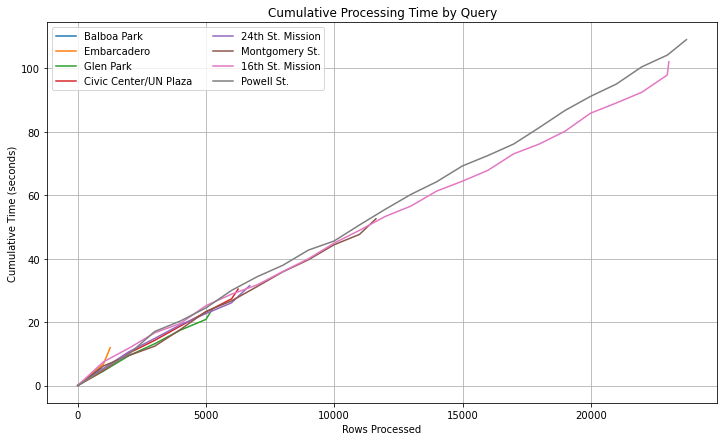

In [165]:
#SF CRIME QUERY PERFORMANCE

# Sample data
data = results[0][1]

# Number of queries
num_queries = len(data)

# Initialize storage for cumulative times and rows processed
cumulative_times = []
cumulative_rows = []

# Process each query
for query in data:
    # Extract processing times and rows processed for this query
    times = [entry[0] for entry in query]
    rows = [entry[1] for entry in query]

    # Calculate cumulative time and rows
    cumulative_times.append(np.cumsum(times))
    cumulative_rows.append(np.cumsum(rows))

# Plotting
plt.figure(figsize=(12, 7))

nameList = ['Balboa Park','Embarcadero', 'Glen Park','Civic Center/UN Plaza','24th St. Mission','Montgomery St.', '16th St. Mission', 'Powell St.']

# Plot cumulative time for each query
for query_idx, name in zip(range(num_queries), nameList):
    times = cumulative_times[query_idx]
    rows = cumulative_rows[query_idx]
    plt.plot([0]+list(rows), [0]+list(times), label=f"{name}")

# Add labels, legend, and grid
plt.title("Cumulative Processing Time by Query")
plt.xlabel("Rows Processed")
plt.ylabel("Cumulative Time (seconds)")
plt.legend(ncol = 2, fontsize='medium', loc = 0)
plt.grid(True)

# Show the plot
plt.show()

OAKLAND CRIME QUERY PERFORMANCE

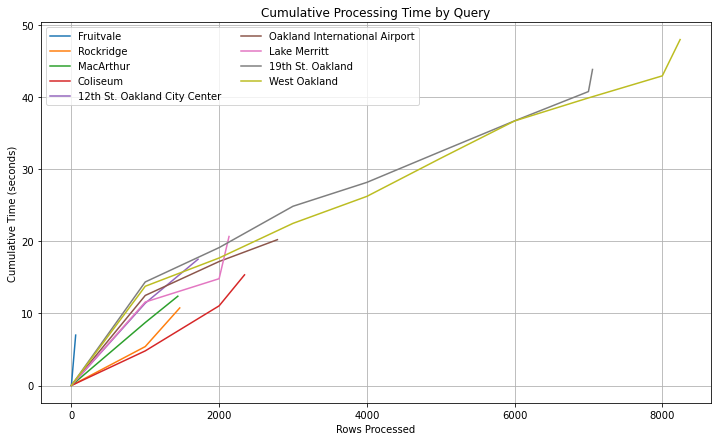

In [164]:
#YELP QUERY PERFORMANCE

# Sample data
data = results[1][1]

# Number of queries
num_queries = len(data)

# Initialize storage for cumulative times and rows processed
cumulative_times = []
cumulative_rows = []

# Process each query
for query in data:
    # Extract processing times and rows processed for this query
    times = [entry[0] for entry in query]
    rows = [entry[1] for entry in query]

    # Calculate cumulative time and rows
    cumulative_times.append(np.cumsum(times))
    cumulative_rows.append(np.cumsum(rows))

# Plotting
plt.figure(figsize=(12, 7))

nameList = ['Fruitvale','Rockridge','MacArthur','Coliseum', '12th St. Oakland City Center','Oakland International Airport', 'Lake Merritt','19th St. Oakland','West Oakland']

# Plot cumulative time for each query
for query_idx, name in zip(range(num_queries), nameList):
    times = cumulative_times[query_idx]
    rows = cumulative_rows[query_idx]
    plt.plot([0]+list(rows), [0]+list(times), label=f"{name}")

# Add labels, legend, and grid
plt.title("Cumulative Processing Time by Query")
plt.xlabel("Rows Processed")
plt.ylabel("Cumulative Time (seconds)")
plt.legend(ncol = 2, fontsize='medium', loc = 0)
plt.grid(True)

# Show the plot
plt.show()

YELP QUERY PERFORMANCE

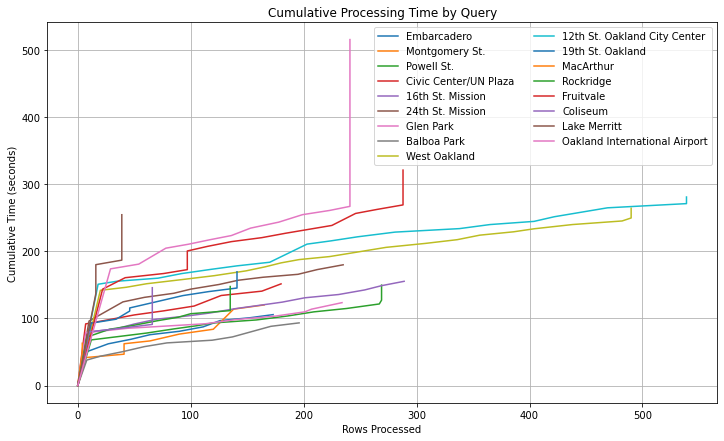

In [166]:
#YELP QUERY PERFORMANCE

# Sample data
data = results[2][1]

# Number of queries
num_queries = len(data)

# Initialize storage for cumulative times and rows processed
cumulative_times = []
cumulative_rows = []

# Process each query
for query in data:
    # Extract processing times and rows processed for this query
    times = [entry[0] for entry in query]
    rows = [entry[1] for entry in query]

    # Calculate cumulative time and rows
    cumulative_times.append(np.cumsum(times))
    cumulative_rows.append(np.cumsum(rows))

# Plotting
plt.figure(figsize=(12, 7))

nameList = ['Embarcadero', 'Montgomery St.', 'Powell St.', 'Civic Center/UN Plaza', '16th St. Mission', '24th St. Mission', 'Glen Park', 'Balboa Park',
            'West Oakland', '12th St. Oakland City Center', '19th St. Oakland', 'MacArthur', 'Rockridge', 'Fruitvale', 'Coliseum', 'Lake Merritt', 'Oakland International Airport']

# Plot cumulative time for each query
for query_idx, name in zip(range(num_queries), nameList):
    times = cumulative_times[query_idx]
    rows = cumulative_rows[query_idx]
    plt.plot([0]+list(rows), [0]+list(times), label=f"{name}")

# Add labels, legend, and grid
plt.title("Cumulative Processing Time by Query")
plt.xlabel("Rows Processed")
plt.ylabel("Cumulative Time (seconds)")
plt.legend(ncol = 2, fontsize='medium', loc = 1)
plt.grid(True)

# Show the plot
plt.show()


DATA MANIPULATION:

In [15]:
names = {"incident_datetime": "datetime", "incident_category": "crime", "description": "crime"}
sfFrame =  util.Rename(results[0][0], names)
oakFrame = util.Rename(results[1][0], names)

crimeData = pd.concat([sfFrame, oakFrame], ignore_index = True)
crimeData['date'] = pd.to_datetime(crimeData['date']).dt.normalize()
crimeData['year'] = crimeData['date'].dt.year
crimeData['month'] = crimeData['date'].dt.month
crimeData['time'] = pd.to_datetime(crimeData['time']).dt.time
crimeData.sample(5)

,crime,isViolent,night,longitude,latitude,date,time,city,station,distance,year,month
50112,Other Miscellaneous,False,False,-122.418271,37.761902,2023-01-18,19:01:00,San Francisco,16th St. Mission,0.152865,2023,1
89255,murder first degree,True,False,-122.267170,37.803610,2022-07-15,21:00:00,Oakland,12th St. Oakland City Center,0.295780,2022,7
33019,Other Miscellaneous,False,False,-122.415172,37.752440,2022-04-15,22:45:00,San Francisco,24th St. Mission,0.205262,2022,4
15262,Lost Property,False,False,-122.413487,37.779992,2022-06-26,15:00:00,San Francisco,Civic Center/UN Plaza,0.044957,2022,6
9425,Larceny Theft,False,False,-122.412158,37.776661,2021-05-31,00:00:00,San Francisco,Civic Center/UN Plaza,0.177117,2021,5


In [16]:
# crimeData.groupby('station').size().reset_index(name = 'Number of Crimes')

result = (
    crimeData.groupby("station")
    .agg(
        crimes_per_station=("crime", "size"),  # Number of crimes per station
        most_common_crime=("crime", lambda x: x.mode()[0]),  # Most common crime
        percent_night=("night", lambda x: x.mean()),  # % crimes at night
        percent_violent=("isViolent", lambda x: x.mean()),  # % violent crimes
        avg_distance=("distance", "mean"),  # Average distance
    )
    .reset_index()
)
display(result)

,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance
0,12th St. Oakland City Center,7052,burglary auto,0.090613,0.119682,0.156881
1,16th St. Mission,11610,Larceny Theft,0.100947,0.158398,0.124149
2,19th St. Oakland,8240,burglary auto,0.087621,0.090534,0.147863
3,24th St. Mission,6695,Larceny Theft,0.105601,0.188051,0.120314
4,Balboa Park,897,Larceny Theft,0.111483,0.131550,0.158883
5,Civic Center/UN Plaza,23728,Drug Offense,0.074258,0.125464,0.133701
6,Coliseum,1466,vehicle theft auto,0.090723,0.114598,0.125511
7,Embarcadero,5251,Larceny Theft,0.055799,0.106646,0.146733
8,Fruitvale,2785,vehicle theft auto,0.109156,0.237702,0.147797
9,Glen Park,1264,Larceny Theft,0.079905,0.072785,0.140189


In [17]:
result = (
    crimeData.groupby(['year', 'month', 'station'])
    .agg(
        crimes_per_station=("crime", "size"),  # Number of crimes per station
        most_common_crime=("crime", lambda x: x.mode()[0]),  # Most common crime
        percent_night=("night", lambda x: x.mean()),  # % crimes at night
        percent_violent=("isViolent", lambda x: x.mean()),  # % violent crimes
        avg_distance=("distance", "mean"),  # Average distance
    )
    .reset_index()
)

result['year_month'] = (
    result['year'].astype(str) + '-' + result['month'].astype(str).str.zfill(2)
)

display(result.sample(5))

,year,month,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month
620,2024,2,19th St. Oakland,111,burglary auto,0.153153,0.099099,0.144010,2024-02
669,2024,5,12th St. Oakland City Center,99,burglary auto,0.131313,0.181818,0.153593,2024-05
580,2023,11,Oakland International Airport,3,embezzle leased/rented vehicle,0.000000,0.000000,0.068482,2023-11
17,2021,2,16th St. Mission,190,Other Miscellaneous,0.089474,0.094737,0.118530,2021-02
638,2024,3,24th St. Mission,135,Assault,0.059259,0.251852,0.119074,2024-03


In [19]:
merged = pd.merge(stationInfo, result, on="station")
merged.shape

(788, 12)

In [ ]:

# Generate full combinations of years, months, and stations
years = merged["year"].unique()
months = range(1, 13)  # 12 months
stations = merged["station"].unique()
all_combinations = pd.DataFrame(list(itertools.product(years, months, stations)), columns=["year", "month", "station"])

station_info = merged.drop_duplicates(subset=["station"])[["station", "city", "gtfs_latitude", "gtfs_longitude"]]
all_combinations = all_combinations.merge(station_info, on="station", how="left")

# Merge with the original DataFrame
geoCrimeFrame = all_combinations.merge(merged, on=["year", "month", "station"], how="left")

geoCrimeFrame["city"] = geoCrimeFrame["city_x"].combine_first(geoCrimeFrame["city_y"])
geoCrimeFrame["gtfs_latitude"] = geoCrimeFrame["gtfs_latitude_x"].combine_first(geoCrimeFrame["gtfs_latitude_y"])
geoCrimeFrame["gtfs_longitude"] = geoCrimeFrame["gtfs_longitude_x"].combine_first(geoCrimeFrame["gtfs_longitude_y"])

# Drop the now-redundant columns
geoCrimeFrame.drop(columns=["city_x", "city_y", "gtfs_latitude_x", "gtfs_latitude_y", "gtfs_longitude_x", "gtfs_longitude_y"], inplace=True)

# Fill missing values
geoCrimeFrame["crimes_per_station"].fillna(0, inplace=True)
geoCrimeFrame["most_common_crime"].fillna("None", inplace=True)  # No crime reported
geoCrimeFrame["percent_night"].fillna(0, inplace=True)
geoCrimeFrame["percent_violent"].fillna(0, inplace=True)
geoCrimeFrame["avg_distance"].fillna(0, inplace=True)

# Recreate 'year_month' column
geoCrimeFrame["year_month"] = geoCrimeFrame["year"].astype(str) + "-" + geoCrimeFrame["month"].astype(str).str.zfill(2)

# Sort the DataFrame by year, month, and station
geoCrimeFrame.sort_values(by=["year", "month", "station"], inplace=True)

# Reset index
geoCrimeFrame.reset_index(drop=True, inplace=True)

display(geoCrimeFrame)

,year,month,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month,city,gtfs_latitude,gtfs_longitude
0,2021,1,12th St. Oakland City Center,89.0,burglary auto,0.067416,0.191011,0.142277,2021-01,Oakland,37.803768,-122.271450
1,2021,1,16th St. Mission,188.0,Other Miscellaneous,0.111702,0.154255,0.125892,2021-01,San Francisco,37.765062,-122.419694
2,2021,1,19th St. Oakland,77.0,burglary auto,0.038961,0.064935,0.127915,2021-01,Oakland,37.808350,-122.268602
3,2021,1,24th St. Mission,111.0,Burglary,0.072072,0.090090,0.122344,2021-01,San Francisco,37.752470,-122.418143
4,2021,1,Balboa Park,10.0,Larceny Theft,0.000000,0.000000,0.156588,2021-01,San Francisco,37.721585,-122.447506
...,...,...,...,...,...,...,...,...,...,...,...,...
811,2024,12,Montgomery St.,3.0,Assault,0.666667,0.666667,0.147482,2024-12,San Francisco,37.789405,-122.401066
812,2024,12,Oakland International Airport,0.0,None,0.000000,0.000000,0.000000,2024-12,Oakland,37.713238,-122.212191
813,2024,12,Powell St.,11.0,Larceny Theft,0.000000,0.090909,0.139793,2024-12,San Francisco,37.784471,-122.407974
814,2024,12,Rockridge,0.0,None,0.000000,0.000000,0.000000,2024-12,Oakland,37.844702,-122.251371


In [100]:
geoCrimeFrame.dtypes

year                    int64
month                   int64
station                object
crimes_per_station    float64
most_common_crime      object
percent_night         float64
percent_violent       float64
avg_distance          float64
year_month             object
city                   object
gtfs_latitude         float64
gtfs_longitude        float64
dtype: object

In [208]:
#Adding ridership to geoCrimeFrame! 
sfStationList = [
    'Embarcadero', 'Balboa Park', 'Glen Park', '24th St. Mission', 'Montgomery St.',
    '16th St. Mission', 'Powell St.', 'Civic Center/UN Plaza'
]
twoLetterCode = ['12', 'OA', 'MA', 'LM', 'RR', 'CL', 'FV', '19', 'OW', 
                 'EM', 'BP' 'GP', '24', 'MT', '16', 'PL', 'CC']



ridership = [117882, 34783+36653, 18860+18446, 38733+39824, 66704+54339, 38834+39024, 98746+83480, 61280+66608,
             2974+2662, 1661+1514, 892+837, 1749+1792, 2740+3305, 1784+1774, 4299+3617, 3117+2860]

In [209]:
import os
# Folder paths and constants
base_folder = "ridership"
years = [2021, 2022, 2023, 2024]
sheet_names = {2021: "Total Trips OD", 2022: "Total Trips OD", 2023: "Total Trips OD", 2024: "Total Trips"}
two_letter_codes = ['12', 12, 'OA', 'MA', 'LM', 'RR', 'CL', 'FV', '19', 19, 'OW', 
                    'EM', 'BP', 'GP', '24', 24, 'MT', '16', 16, 'PL', 'CC']

# Initialize an empty DataFrame for results
result_df = pd.DataFrame(columns=["year", "month", "year_month", "station", "ridership"])

# Loop through each year and month
for year in years:
    year_folder = os.path.join(base_folder, f"ridership_{year}")
    for month in range(1, 13):
        file_name = f"Ridership_{year}{str(month).zfill(2)}.xlsx"
        file_path = os.path.join(year_folder, file_name)

        # Read the file from the repository (local relative path)
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        # Read the appropriate sheet from the Excel file
        sheet_name = sheet_names[year]
        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        # Adjust data based on year-specific conditions
        if year in [2021, 2022, 2023]:
            df = df.iloc[1:-1]  # Ignore the first row and the last row
            station_col = "Exit stations"
            ridership_col = df.columns[-1]  # Last column
        elif year == 2024:
            df = df.iloc[4:-1]  # Ignore the first four rows and the last row
            station_col = "Total Trip OD"
            ridership_col = df.columns[-1]  # Last column
        else:
            print(f"Year {year} not supported.")
            continue

        # Filter for rows with valid station codes
        if station_col not in df.columns or ridership_col not in df.columns:
            print(f"Could not locate required columns in {file_path}")
            continue

        filtered_df = df[df[station_col].isin(two_letter_codes)].copy()

        # Create the year, month, and year_month columns
        filtered_df.loc[:, "year"] = year
        filtered_df.loc[:, "month"] = month
        filtered_df.loc[:, "year_month"] = f"{year}-{str(month).zfill(2)}"

        # Select and rename columns
        filtered_df = filtered_df[["year", "month", "year_month", station_col, ridership_col]]
        filtered_df.columns = ["year", "month", "year_month", "station", "ridership"]

        # Append to the result DataFrame
        result_df = pd.concat([result_df, filtered_df], ignore_index=True)

# Extend data for missing months
for station in two_letter_codes:
    for month in [11, 12]:  # Months to fill for 2024
        if not ((result_df["year"] == 2024) & (result_df["month"] == month) & (result_df["station"] == station)).any():
            # Get data from the previous available month
            prev_data = result_df[(result_df["year"] == 2024) & (result_df["month"] == month - 1) & (result_df["station"] == station)]
            if not prev_data.empty:
                new_row = prev_data.iloc[0].copy()
                new_row["month"] = month
                new_row["year_month"] = f"2024-{str(month).zfill(2)}"
                result_df = pd.concat([result_df, pd.DataFrame([new_row])], ignore_index=True)

File not found: ridership/ridership_2024/Ridership_202411.xlsx
File not found: ridership/ridership_2024/Ridership_202412.xlsx


In [210]:

# Display the final DataFrame
result_df.replace({"station": {'12': '12th St. Oakland City Center', 12: '12th St. Oakland City Center', 
                                    'OA': 'Oakland International Airport', 'MA': 'MacArthur', 
                                    'LM': "Lake Merritt", 'RR': 'Rockridge', 'CL': 'Coliseum', 
                                    'FV': 'Fruitvale', '19': '19th St. Oakland', 19: '19th St. Oakland', 'OW': "West Oakland", 
                    'EM': "Embarcadero", 'BP': "Balboa Park", 'GP': "Glen Park", '24': '24th St. Mission', 
                    24: '24th St. Mission', 'MT': "Montgomery St.", '16': '16th St. Mission', 16: '16th St. Mission', 
                    'PL': "Powell St.", 'CC': "Civic Center/UN Plaza"}}, inplace = True)
result_df['year'] = result_df['year'].astype(int) 
result_df['month'] = result_df['month'].astype(int)
display(result_df)
result_df.dtypes

,year,month,year_month,station,ridership
0,2021,1,2021-01,MacArthur,24838.0
1,2021,1,2021-01,19th St. Oakland,21718.0
2,2021,1,2021-01,12th St. Oakland City Center,27587.0
3,2021,1,2021-01,Lake Merritt,21843.0
4,2021,1,2021-01,Fruitvale,42621.0
...,...,...,...,...,...
811,2024,12,2024-12,16th St. Mission,162851.0
812,2024,11,2024-11,Powell St.,323917.0
813,2024,12,2024-12,Powell St.,323917.0
814,2024,11,2024-11,Civic Center/UN Plaza,256853.0


year           int64
month          int64
year_month    object
station       object
ridership     object
dtype: object

In [211]:
#Append ridership info to geoCrimeFrame
geoCrimeFrame = pd.merge(geoCrimeFrame, result_df, on = ['station', 'year_month', 'year', 'month'])
display(geoCrimeFrame)

,year,month,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month,city,gtfs_latitude,gtfs_longitude,ridership
0,2021,1,12th St. Oakland City Center,89.0,burglary auto,0.067416,0.191011,0.142277,2021-01,Oakland,37.803768,-122.271450,27587.0
1,2021,1,16th St. Mission,188.0,Other Miscellaneous,0.111702,0.154255,0.125892,2021-01,San Francisco,37.765062,-122.419694,38834.0
2,2021,1,19th St. Oakland,77.0,burglary auto,0.038961,0.064935,0.127915,2021-01,Oakland,37.808350,-122.268602,21718.0
3,2021,1,24th St. Mission,111.0,Burglary,0.072072,0.090090,0.122344,2021-01,San Francisco,37.752470,-122.418143,39824.0
4,2021,1,Balboa Park,10.0,Larceny Theft,0.000000,0.000000,0.156588,2021-01,San Francisco,37.721585,-122.447506,34783.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,2024,12,Montgomery St.,3.0,Assault,0.666667,0.666667,0.147482,2024-12,San Francisco,37.789405,-122.401066,363337.0
812,2024,12,Oakland International Airport,0.0,None,0.000000,0.000000,0.000000,2024-12,Oakland,37.713238,-122.212191,17687.0
813,2024,12,Powell St.,11.0,Larceny Theft,0.000000,0.090909,0.139793,2024-12,San Francisco,37.784471,-122.407974,323917.0
814,2024,12,Rockridge,0.0,None,0.000000,0.000000,0.000000,2024-12,Oakland,37.844702,-122.251371,74063.0


In [181]:
# Rows in geoCrimeFrame with no match in result_df
missing_from_result = geoCrimeFrame.merge(result_df, on=['station', 'year_month', 'year', 'month'], how='left', indicator=True)
missing_from_result = missing_from_result[missing_from_result['_merge'] == 'left_only']
display(missing_from_result)

# Rows in result_df with no match in geoCrimeFrame
missing_from_geo = result_df.merge(geoCrimeFrame, on=['station', 'year_month', 'year', 'month'], how='left', indicator=True)
missing_from_geo = missing_from_geo[missing_from_geo['_merge'] == 'left_only']
display(missing_from_geo)

,year,month,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month,city,gtfs_latitude,gtfs_longitude,ridership_x,ridership_y,_merge


,year,month,year_month,station,ridership_x,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,city,gtfs_latitude,gtfs_longitude,ridership_y,_merge


FINAL DATA FRAME

In [212]:
geoCrimeFrame = pd.merge(geoCrimeFrame, sentimentStation, on = ['city', 'station'])

In [213]:
# for i in (geoCrimeFrame['crimes_per_station']/geoCrimeFrame['ridership']) * 100000:
#     print(i)
geoCrimeFrame['crimes_per_100k'] = (geoCrimeFrame['crimes_per_station']/geoCrimeFrame['ridership']) * 100000
geoCrimeFrame['crimePercentage'] = (geoCrimeFrame['crimes_per_station']/geoCrimeFrame['ridership'])

display(geoCrimeFrame)

,year,month,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month,city,gtfs_latitude,gtfs_longitude,ridership,overallSentiment,crimes_per_100k,crimePercentage
0,2021,1,12th St. Oakland City Center,89.0,burglary auto,0.067416,0.191011,0.142277,2021-01,Oakland,37.803768,-122.27145,27587.0,0.102107,322.615725,0.003226
1,2021,2,12th St. Oakland City Center,99.0,burglary auto,0.090909,0.181818,0.167127,2021-02,Oakland,37.803768,-122.27145,29238.0,0.102107,338.600451,0.003386
2,2021,3,12th St. Oakland City Center,88.0,burglary auto,0.079545,0.272727,0.152201,2021-03,Oakland,37.803768,-122.27145,37742.0,0.102107,233.161995,0.002332
3,2021,4,12th St. Oakland City Center,103.0,burglary auto,0.106796,0.174757,0.179540,2021-04,Oakland,37.803768,-122.27145,41420.0,0.102107,248.672139,0.002487
4,2021,5,12th St. Oakland City Center,152.0,burglary auto,0.125000,0.111842,0.170308,2021-05,Oakland,37.803768,-122.27145,44183.0,0.102107,344.02372,0.00344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,2024,8,West Oakland,35.0,vehicle theft auto,0.057143,0.028571,0.125911,2024-08,Oakland,37.804872,-122.29514,92431,0.208704,37.866084,0.000379
812,2024,9,West Oakland,31.0,burglary auto,0.064516,0.193548,0.108108,2024-09,Oakland,37.804872,-122.29514,91727.0,0.208704,33.795938,0.000338
813,2024,10,West Oakland,35.0,vehicle theft auto,0.000000,0.085714,0.130098,2024-10,Oakland,37.804872,-122.29514,98761.0,0.208704,35.43909,0.000354
814,2024,11,West Oakland,30.0,vehicle theft auto,0.000000,0.233333,0.121280,2024-11,Oakland,37.804872,-122.29514,98761.0,0.208704,30.376363,0.000304


In [214]:
geoCrimeFrame['crimes_per_100k'] = geoCrimeFrame['crimes_per_100k'].astype(float)
geoCrimeFrame.dtypes

year                    int64
month                   int64
station                object
crimes_per_station    float64
most_common_crime      object
percent_night         float64
percent_violent       float64
avg_distance          float64
year_month             object
city                   object
gtfs_latitude         float64
gtfs_longitude        float64
ridership              object
overallSentiment      float64
crimes_per_100k       float64
crimePercentage        object
dtype: object

In [311]:
geoCrimeFrame.loc[geoCrimeFrame['station'] == 'Oakland International Airport', 'overallSentiment'] = 0.39086842105263153
station_sentiment_ranks = (
    geoCrimeFrame.groupby('station')['overallSentiment']
    .mean()  # Mean is redundant here since overallSentiment is static
    .rank(method='dense', ascending=False)  # Rank highest sentiment as 1
    .astype(int)  # Convert rank to integer
    .to_dict()  # Create a dictionary mapping station to rank
)

# Map sentiment rank back to the original DataFrame
geoCrimeFrame['sentiment_rank'] = geoCrimeFrame['station'].map(station_sentiment_ranks)

In [322]:
geoCrimeFrame.to_csv('all_data_by_month')

In [317]:
display(geoCrimeFrame)

,year,month,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month,city,gtfs_latitude,gtfs_longitude,ridership,overallSentiment,crimes_per_100k,crimePercentage,sentiment_rank,predicted_sentiment
0,2021,1,12th St. Oakland City Center,89.0,burglary auto,0.067416,0.191011,0.142277,2021-01,Oakland,37.803768,-122.27145,27587.0,0.102107,322.615725,0.003226,12,0.085117
1,2021,2,12th St. Oakland City Center,99.0,burglary auto,0.090909,0.181818,0.167127,2021-02,Oakland,37.803768,-122.27145,29238.0,0.102107,338.600451,0.003386,12,0.080832
2,2021,3,12th St. Oakland City Center,88.0,burglary auto,0.079545,0.272727,0.152201,2021-03,Oakland,37.803768,-122.27145,37742.0,0.102107,233.161995,0.002332,12,0.109096
3,2021,4,12th St. Oakland City Center,103.0,burglary auto,0.106796,0.174757,0.179540,2021-04,Oakland,37.803768,-122.27145,41420.0,0.102107,248.672139,0.002487,12,0.104938
4,2021,5,12th St. Oakland City Center,152.0,burglary auto,0.125000,0.111842,0.170308,2021-05,Oakland,37.803768,-122.27145,44183.0,0.102107,344.023720,0.00344,12,0.079378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,2024,8,West Oakland,35.0,vehicle theft auto,0.057143,0.028571,0.125911,2024-08,Oakland,37.804872,-122.29514,92431,0.208704,37.866084,0.000379,5,0.161447
812,2024,9,West Oakland,31.0,burglary auto,0.064516,0.193548,0.108108,2024-09,Oakland,37.804872,-122.29514,91727.0,0.208704,33.795938,0.000338,5,0.162538
813,2024,10,West Oakland,35.0,vehicle theft auto,0.000000,0.085714,0.130098,2024-10,Oakland,37.804872,-122.29514,98761.0,0.208704,35.439090,0.000354,5,0.162098
814,2024,11,West Oakland,30.0,vehicle theft auto,0.000000,0.233333,0.121280,2024-11,Oakland,37.804872,-122.29514,98761.0,0.208704,30.376363,0.000304,5,0.163455


In [ ]:
#Aggregate dataframe (ignoring time)
total_crimes_per_station = (
    geoCrimeFrame.groupby("station").agg(
        total_crimes_100k=("crimes_per_100k", "sum"),  # Sum crimes
        most_common_crime=("most_common_crime", "first"),  # Keep static values
        percent_violent = ('percent_violent', 'first'),
        percent_night = ('percent_night', 'first'),
        avg_distance=("avg_distance", "first"),
        ridership = ('ridership', 'first'),
        gtfs_latitude=("gtfs_latitude", "first"),
        gtfs_longitude=("gtfs_longitude", "first"),
        overallSentiment=("overallSentiment", "first"),
        sentiment_rank = ('sentiment_rank', 'first')
    )
    .reset_index()
)
display(total_crimes_per_station)

,station,total_crimes_100k,most_common_crime,percent_violent,percent_night,avg_distance,ridership,gtfs_latitude,gtfs_longitude,overallSentiment,sentiment_rank
0,12th St. Oakland City Center,8245.479053,burglary auto,0.191011,0.067416,0.142277,27587.0,37.803768,-122.271450,0.102107,12
1,16th St. Mission,10288.534782,Other Miscellaneous,0.154255,0.111702,0.125892,38834.0,37.765062,-122.419694,0.057989,16
2,19th St. Oakland,10642.839196,burglary auto,0.064935,0.038961,0.127915,21718.0,37.808350,-122.268602,0.068230,15
3,24th St. Mission,5997.396366,Burglary,0.090090,0.072072,0.122344,39824.0,37.752470,-122.418143,0.099162,13
4,Balboa Park,1169.883778,Larceny Theft,0.000000,0.000000,0.156588,34783.0,37.721585,-122.447506,0.119982,10
5,Civic Center/UN Plaza,13961.981344,Drug Offense,0.106818,0.054545,0.139022,61280.0,37.779732,-122.414123,0.072959,14
6,Coliseum,2568.452805,vehicle theft auto,0.172414,0.034483,0.124658,25838.0,37.753661,-122.196869,0.212557,4
7,Embarcadero,2092.468768,Larceny Theft,0.066667,0.066667,0.150226,61670.0,37.792874,-122.397020,0.027080,17
8,Fruitvale,3330.584357,vehicle theft auto,0.312500,0.140625,0.172595,42621.0,37.774836,-122.224175,0.179238,7
9,Glen Park,2413.193222,Larceny Theft,0.058824,0.029412,0.152884,18446.0,37.733064,-122.433817,0.339844,2


In [326]:
total_crimes_per_station[['station','overallSentiment','sentiment_rank']]

,station,overallSentiment,sentiment_rank
0,12th St. Oakland City Center,0.102107,12
1,16th St. Mission,0.057989,16
2,19th St. Oakland,0.068230,15
3,24th St. Mission,0.099162,13
4,Balboa Park,0.119982,10
5,Civic Center/UN Plaza,0.072959,14
6,Coliseum,0.212557,4
7,Embarcadero,0.027080,17
8,Fruitvale,0.179238,7
9,Glen Park,0.339844,2


In [321]:
total_crimes_per_station.to_csv('all_data_aggregate')

Visualization of data

<Figure size 864x432 with 0 Axes>

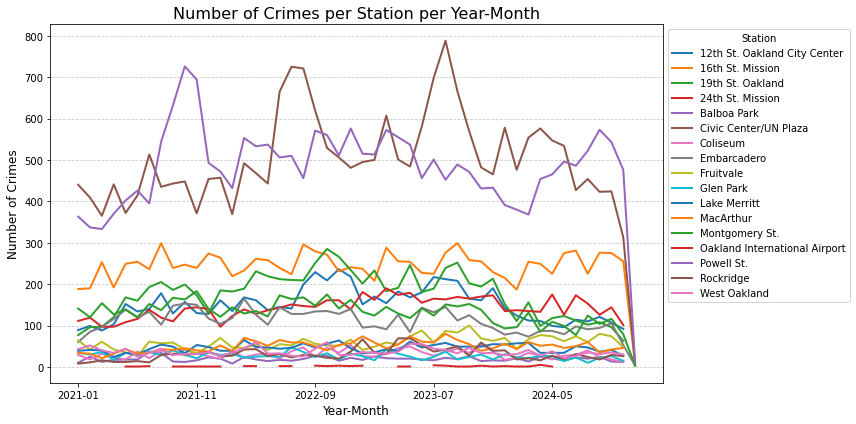

In [18]:
import matplotlib.pyplot as plt

# Pivot the data to have stations as columns and year_month as rows
crime_summary = result.pivot(index='year_month', columns='station', values='crimes_per_station')

# Plot the data
plt.figure(figsize=(12, 6))
crime_summary.plot(linewidth=2, figsize=(12, 6))
plt.title('Number of Crimes per Station per Year-Month', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Station', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [335]:
import plotly.express as px

# geoCrimeFrame["scaled_crimes"] = geoCrimeFrame["crimes_per_station"] ** 0.5 
fig = px.scatter_mapbox(
    geoCrimeFrame,
    lat="gtfs_latitude",
    lon="gtfs_longitude",
    size="crimes_per_100k",
    color="overallSentiment",
    color_continuous_scale="RdYlGn",
    animation_frame="year_month",  # Animation over time
    hover_name="station",
    hover_data={"crimes_per_station": True, "most_common_crime": True, "percent_night": True, 
                "percent_violent": True, "avg_distance": True, "ridership": True, "overallSentiment": True, "gtfs_latitude": False, "gtfs_longitude": False},
    mapbox_style="carto-darkmatter",  # Use a light map style
    zoom=11,  # Zoom level for the Bay Area
    title="Crime Trends Per Station Over Time",
)
fig.update_layout(
    height=750,  # Increase figure height
    width=1275   # Increase figure width
)


# Show the map
fig.show()

In [336]:
fig.write_html("visualizations/crime_sentiment_over_time.html")

In [337]:
fig = px.scatter_mapbox(
    geoCrimeFrame,
    lat="gtfs_latitude",
    lon="gtfs_longitude",
    size="crimes_per_100k",
    color="percent_night",
    color_continuous_scale="sunset",
    animation_frame="year_month",  # Animation over time
    hover_name="station",
    hover_data={"crimes_per_station": True, "most_common_crime": True, "percent_night": True, 
                "percent_violent": True, "avg_distance": True, "ridership": True, "overallSentiment": True, "gtfs_latitude": False, "gtfs_longitude": False},
    mapbox_style="carto-darkmatter",  # Use a light map style
    zoom=11,  # Zoom level for the Bay Area
    title="Crime Trends Per Station Over Time",
)
fig.update_layout(
    height=750,  # Increase figure height
    width=1275   # Increase figure width
)


# Show the map
fig.show()

In [338]:
fig.write_html("visualizations/crime_night_over_time.html")

In [339]:
fig = px.scatter_mapbox(
    geoCrimeFrame,
    lat="gtfs_latitude",
    lon="gtfs_longitude",
    size="crimes_per_100k",
    color="percent_violent",
    color_continuous_scale="sunset",
    animation_frame="year_month",  # Animation over time
    hover_name="station",
    hover_data={"crimes_per_station": True, "most_common_crime": True, "percent_night": True, 
                "percent_violent": True, "avg_distance": True, "ridership": True, "overallSentiment": True, "gtfs_latitude": False, "gtfs_longitude": False},
    mapbox_style="carto-darkmatter",  # Use a light map style
    zoom=11,  # Zoom level for the Bay Area
    title="Crime Trends Per Station Over Time",
)
fig.update_layout(
    height=750,  # Increase figure height
    width=1275   # Increase figure width
)


# Show the map
fig.show()

In [340]:
fig.write_html("visualizations/crime_violent_over_time.html")

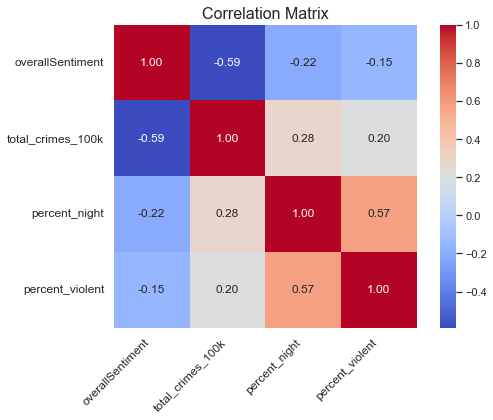

In [353]:
# Select variables for the correlation matrix
columns_of_interest = ["overallSentiment", "total_crimes_100k", "percent_night", "percent_violent"]
correlation_data = total_crimes_per_station[columns_of_interest]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Show correlation coefficients
    cmap="coolwarm",  # Use a diverging colormap
    fmt=".2f",  # Format numbers to two decimal places
    cbar=True,  # Include a colorbar
    square=True,  # Make cells square-shaped
)

# Add titles and labels
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [342]:
plt.savefig('visualizations/correlation_matrix.png')

<Figure size 432x288 with 0 Axes>

In [343]:
import plotly.graph_objects as go
fig = px.scatter_mapbox(
    total_crimes_per_station,
    lat="gtfs_latitude",
    lon="gtfs_longitude",
    size="total_crimes_100k",
    color="overallSentiment",
    color_continuous_scale="RdYlGn",
    # animation_frame="year_month",  # Animation over time
    hover_name="station",
    hover_data={"most_common_crime": True, "percent_night": True, 
                "percent_violent": True, "avg_distance": True, "ridership": True, "overallSentiment": True, "gtfs_latitude": False, "gtfs_longitude": False},
    mapbox_style="carto-darkmatter",  # Use a light map style
    zoom=11,  # Zoom level for the Bay Area
    title="Crime per 100k Riders With Online Sentiment 2021-2024",
)
fig = go.Figure(fig)

def normalize_and_scale(column, scale_factor=1000):
    min_val = column.min()
    max_val = column.max()
    return ((column - min_val) / (max_val - min_val)) * scale_factor

# Normalize and scale all potential size factors
scaled_columns = {}
size_factors = ["total_crimes_100k", "ridership", "percent_night", "percent_violent", 'avg_distance']

for factor in size_factors:
    scaled_columns[factor] = normalize_and_scale(total_crimes_per_station[factor], scale_factor=50)

# Create the initial figure with the normalized size for the default factor
default_factor = "total_crimes_100k"
fig = px.scatter_mapbox(
    total_crimes_per_station,
    lat="gtfs_latitude",
    lon="gtfs_longitude",
    size=scaled_columns[default_factor],  # Use normalized size
    color="overallSentiment",
    color_continuous_scale="RdYlGn",
    hover_name="station",
    hover_data={
        "most_common_crime": True, "percent_night": True,
        "percent_violent": True, "avg_distance": True, "ridership": True, "overallSentiment": True,
        "gtfs_latitude": False, "gtfs_longitude": False
    },
    mapbox_style="carto-darkmatter",
    zoom=11,
    title=f"Crime Map - Circle Size by {default_factor}",
)

# Convert to a graph object to add dynamic scaling through a dropdown
fig = go.Figure(fig)

# Create dropdown buttons for each factor
dropdown_buttons = [
    {
        "label": factor,
        "method": "update",
        "args": [
            {
                "marker": {"size": scaled_columns[factor],
                           "color": total_crimes_per_station["overallSentiment"],  # Keep the color scale
                    "colorscale": "RdYlGn",  # Retain the color scale
                    "colorbar": {"title": "Sentiment"},  # Add a color bar title
                    },  # Update with normalized size
            },
            {
                "title": f"BART Crime Map With Online Sentiment - Circle Size by {factor}",  # Update title
            },
        ],
    }
    for factor in size_factors
]

# Add dropdown menu to the figure
fig.update_layout(
    updatemenus=[
        {
            "buttons": dropdown_buttons,
            "direction": "down",
            "showactive": True,
            "x": 1,
            "y": 1.15,
            "xanchor": "left",
            "yanchor": "top",
        }
    ],
    height=750,
    width=1275,
)

# Show the map
fig.show()

In [344]:
fig.write_html("visualizations/crime_info_circle_size.html")

In [345]:
fig = px.bar(
    geoCrimeFrame,
    x="crimes_per_100k",
    y="station",
    color="percent_violent",
    color_continuous_scale="sunset",
    animation_frame="year_month",
    title="Crime Rates by Station Over Time",
    labels={"crimes_per_100k": "Crimes per 100k Riders", "station": "Station"}
)

fig.show()

In [346]:
fig.write_html("visualizations/crime_violent_over_time_bar.html")

In [347]:
fig = px.bar(
    geoCrimeFrame,
    x="crimes_per_100k",
    y="station",
    color="percent_night",
    color_continuous_scale="sunset",
    animation_frame="year_month",
    title="Crime Rates by Station Over Time",
    labels={"crimes_per_100k": "Crimes per 100k Riders", "station": "Station"}
)

fig.show()

In [348]:
fig.write_html("visualizations/crime_night_over_time_bar.html")

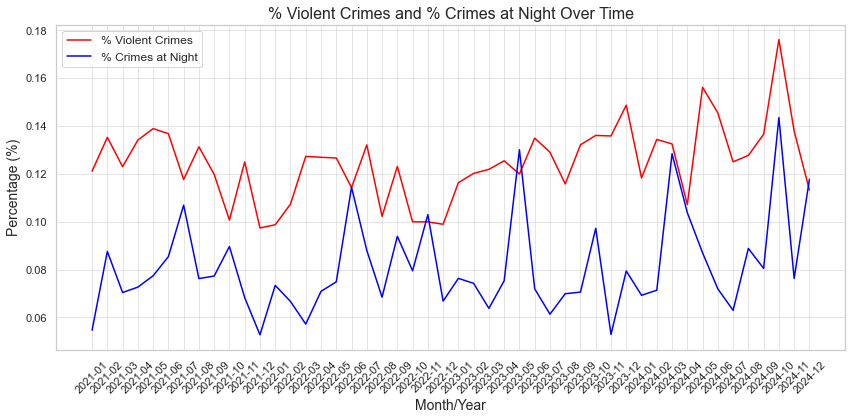

In [349]:
aggregated_data = geoCrimeFrame.groupby('year_month')[['percent_violent', 'percent_night']].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))

# Plot percent_violent
plt.plot(
    aggregated_data['year_month'], 
    aggregated_data['percent_violent'], 
    label='% Violent Crimes', 
    color='red'
)

# Plot percent_night
plt.plot(
    aggregated_data['year_month'], 
    aggregated_data['percent_night'], 
    label='% Crimes at Night', 
    color='blue'
)

# Add titles and labels
plt.title('% Violent Crimes and % Crimes at Night Over Time', fontsize=16)
plt.xlabel('Month/Year', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [350]:
plt.savefig('visualizations/violent_night_over_time.png')

<Figure size 432x288 with 0 Axes>

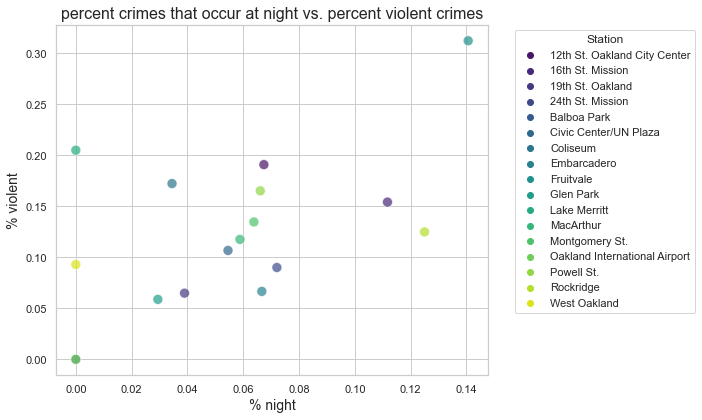

In [351]:
import seaborn as sns
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=total_crimes_per_station, 
    x="percent_night", 
    y="percent_violent", 
    hue="station",  # Optional: to differentiate by station
    palette="viridis",  # Color palette
    alpha=0.7,  # Transparency for better visibility of overlapping points
    s=100  # Size of the points
)

# Add titles and labels
plt.title("percent crimes that occur at night vs. percent violent crimes", fontsize=16)
plt.xlabel("% night", fontsize=14)
plt.ylabel("% violent", fontsize=14)

# Show the legend
plt.legend(title="Station", bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


In [352]:
plt.savefig('visualizations/violent_night_alt.png')

<Figure size 432x288 with 0 Axes>